## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [1]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

from pprint import pprint
import pickle

import warnings
warnings.filterwarnings("ignore")

C:\Anaconda\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
C:\Users\mallikarjuna.manne\AppData\Roaming\Python\Python38\site-packages\spacy\util.py:865: UserWarning: [W095] Model 'en_core_web_sm' (3.0.0) was trained with spaCy v3.0 and may not be 100% compatible with the current version (3.4.1). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [2]:
# Opening JSON file 
f = open('complaints-2021-05-14_08_16.json','r')# Write the path to your data file and load it 
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [3]:
# Inspect the dataframe to understand the given data.
print(df.info())
print(df.describe())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [4]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [5]:
#Assign new column names
df.columns = ['index', 'type', 'id', 'score', 'tags', 'zip_code','complaint_id', 'issue', 'date_received',
       'state', 'consumer_disputed', 'product','company_response', 'company', 'submitted_via',
       'date_sent_to_company', 'company_public_response','sub_product', 'timely',
       'complaint_what_happened', 'sub_issue','consumer_consent_provided']

In [6]:
#Assign nan in place of blanks in the complaints column
df[df.loc[:, 'complaint_what_happened'] == ''] = np.nan

In [7]:
#Remove all rows where complaints column is nan
#df.complaint_what_happened.dropna()
df = df[~df['complaint_what_happened'].isnull()]

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [8]:
# Function to clean the text and remove all the unnecessary elements.
def preprocess_text(text):
    #Make the text lowercase
    text=text.lower()
    #Remove text in square brackets
    text=re.sub(r'\[.*?\]','',text)
    #Remove punctuation
    text=re.sub(r'[^\w\s]', '', text)
    #Remove words containing numbers
    text = re.sub(r'\w*\d\w*', '', text)
    return text

In [9]:
#Function to Lemmatize the texts
def lemmatize_text(text):
    lemma_list=[]
    doc=nlp(text)
    for word in doc:
        lemma_list.append(word.lemma_)
    return " ".join(lemma_list)

In [10]:
#New dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean = pd.DataFrame(df['complaint_what_happened'].apply(lambda x: preprocess_text(x)))
df_clean['lemmatized_complaints'] = df_clean['complaint_what_happened'].apply(lambda x: lemmatize_text(x))

In [11]:
df_clean

,complaint_what_happened,lemmatized_complaints
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...
...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call cha my xxxx xxxx ...
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...
78311,i have had flawless credit for yrs ive had ch...,I have have flawless credit for yrs I ve hav...


In [12]:
#Function to extract the POS tags 
def pos_tag(text):
    # write your code here
    POS_list=[]
    tokens = nltk.word_tokenize(text)
    tag = nltk.pos_tag(tokens)
    for (word,tag) in tag:
        if tag=='NN':
            POS_list.append(word)
    return " ".join(POS_list)
df_clean["complaint_POS_removed"] = df_clean['lemmatized_complaints'].apply(lambda x:pos_tag(x)) #this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].

In [13]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,complaint_what_happened,lemmatized_complaints,complaint_POS_removed
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket offer ticket card informa...
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...
...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,card customer decade solicitation credit card ...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call cha my xxxx xxxx ...,visa credit card provider claim purchase prote...
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk provide consumer bank app chase year ...
78311,i have had flawless credit for yrs ive had ch...,I have have flawless credit for yrs I ve hav...,credit yrs credit card chase freedom xxxx prob...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




Text(0, 0.5, 'Number of Complaints')

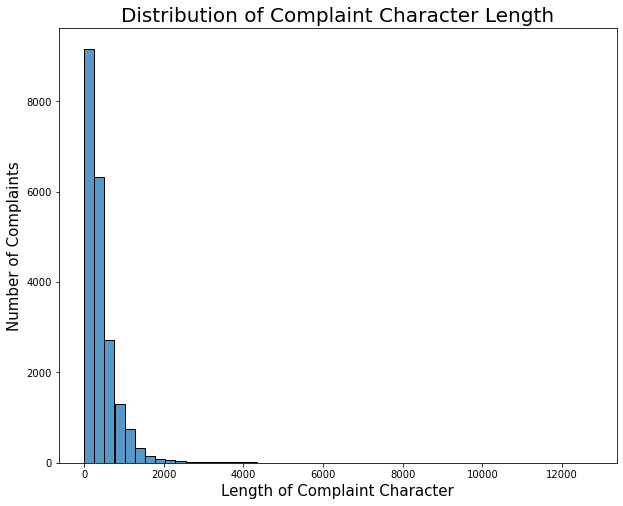

In [14]:
# Visualise the data according to the 'Complaint' character length
len_comp_char=[len(x) for x in df_clean.complaint_POS_removed.values]
plt.figure(figsize=[10,8])
sns.histplot(data = len_comp_char,bins=50)
plt.title('Distribution of Complaint Character Length', fontsize=20)
plt.xlabel('Length of Complaint Character',size=15)
plt.ylabel('Number of Complaints',size=15)

#### Find the top 40 words by frequency among all the articles after processing the text.

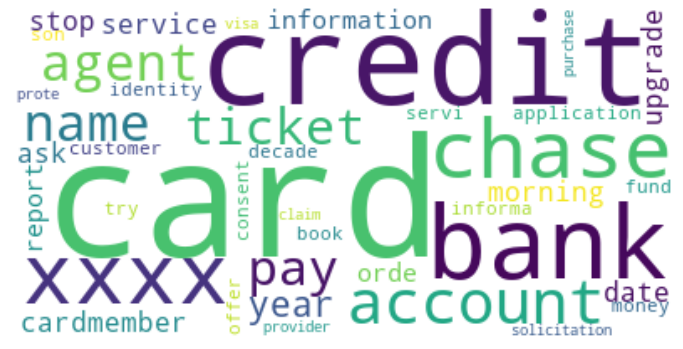

In [15]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
word_cloud = WordCloud(max_words=40, collocations = False, background_color = 'white')
word_cloud.generate(str(df_clean.complaint_POS_removed))
plt.figure(figsize=(12,12))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [16]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [17]:
#Find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
def top_unigrams(text):
    c_vector = CountVectorizer(stop_words='english').fit(text)
    bag_of_words = c_vector.transform(text)
    sum_of_words = bag_of_words.sum(axis=0) 
    word_freq = [(word, sum_of_words[0, idx]) for word, idx in c_vector.vocabulary_.items()]
    word_freq =sorted(word_freq, key = lambda x: x[1], reverse=True)
    return word_freq[:30]

In [18]:
#Print the top 10 words in the unigram frequency
top_30_words = top_unigrams(df_clean['complaint_POS_removed'].values.astype('U'))
df_unigram = pd.DataFrame(top_30_words, columns=['unigram', 'count'])
df_unigram.head(10)

,unigram,count
0,account,47499
1,chase,46729
2,xxxx,36542
3,credit,34129
4,card,29286
5,bank,28420
6,payment,21167
7,time,16055
8,charge,15011
9,day,12972


In [19]:
#Find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
def top_bigrams(text):
    c_vector = CountVectorizer(ngram_range=(2, 2),stop_words='english').fit(text)
    bag_of_words = c_vector.transform(text)
    sum_of_words = bag_of_words.sum(axis=0) 
    word_freq = [(word, sum_of_words[0, idx]) for word, idx in c_vector.vocabulary_.items()]
    word_freq =sorted(word_freq, key = lambda x: x[1], reverse=True)
    return word_freq[:30]

In [20]:
#Print the top 10 words in the bigram frequency
top_30_words = top_bigrams(df_clean['complaint_POS_removed'].values.astype('U'))
df_bigram = pd.DataFrame(top_30_words, columns=['bigram', 'count'])
df_bigram.head(10)

,bigram,count
0,credit card,12778
1,credit report,3928
2,xxxx xxxx,3925
3,customer service,3081
4,chase credit,2960
5,chase bank,2957
6,bank account,2781
7,chase account,2630
8,account chase,2600
9,account account,2411


In [21]:
#Find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
def top_trigrams(text):
    c_vector = CountVectorizer(ngram_range=(3, 3),stop_words='english').fit(text)
    bag_of_words = c_vector.transform(text)
    sum_of_words = bag_of_words.sum(axis=0) 
    word_freq = [(word, sum_of_words[0, idx]) for word, idx in c_vector.vocabulary_.items()]
    word_freq = sorted(word_freq, key = lambda x: x[1], reverse=True)
    return word_freq[:30]

In [22]:
#Print the top 10 words in the trigram frequency
top_30_words = top_trigrams(df_clean['complaint_POS_removed'].values.astype('U'))
df_trigram = pd.DataFrame(top_30_words, columns=['trigram', 'count'])
df_trigram.head(10)

,trigram,count
0,chase credit card,2059
1,credit card account,1025
2,credit card company,991
3,credit card chase,631
4,credit card credit,514
5,inquiry credit report,481
6,charge credit card,420
7,xxxx xxxx xxxx,416
8,account credit card,401
9,card credit card,386


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [23]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [24]:
#All masked texts has been removed
df_clean

,complaint_what_happened,lemmatized_complaints,complaint_POS_removed,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,card report application identity consent servi...
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...
...,...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,card customer decade solicitation credit card ...,card customer decade solicitation credit card ...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call cha my xxxx xxxx ...,visa credit card provider claim purchase prote...,visa credit card provider claim purchase prote...
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk provide consumer bank app chase year ...,pay risk provide consumer bank app chase year ...
78311,i have had flawless credit for yrs ive had ch...,I have have flawless credit for yrs I ve hav...,credit yrs credit card chase freedom xxxx prob...,credit yrs credit card chase freedom problem ...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [25]:
#Initialise the TfidfVectorizer 
tfidf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [26]:
#Document Term Matrix by transforming the complaints column present in df_clean.
doc_term_matrix = tfidf.fit_transform(df_clean['Complaint_clean'])

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [27]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [28]:
#Load nmf_model with the n_components i.e 5
num_topics = 5

#random_state =40
nmf_model = NMF(random_state=40, n_components=num_topics)

In [29]:
nmf_model.fit(doc_term_matrix)
len(tfidf.get_feature_names())

7255

In [30]:
#Print the Top15 words for each of the topics
words = np.array(tfidf.get_feature_names())
for i in range(num_topics):
    ix = nmf_model.components_[i].argsort()[::-1][:15]
    print("Topic-"+str(i+1))
    print(words[ix])
    print('--------------')

Topic-1
['account' 'bank' 'check' 'money' 'fund' 'chase' 'deposit' 'branch' 'day'
 'number' 'business' 'transaction' 'checking' 'claim' 'transfer']
--------------
Topic-2
['credit' 'card' 'report' 'inquiry' 'chase' 'account' 'score' 'company'
 'limit' 'information' 'debt' 'application' 'letter' 'year' 'balance']
--------------
Topic-3
['payment' 'balance' 'month' 'fee' 'statement' 'day' 'time' 'auto' 'date'
 'pay' 'credit' 'account' 'chase' 'year' 'mortgage']
--------------
Topic-4
['charge' 'card' 'fee' 'transaction' 'dispute' 'chase' 'merchant'
 'purchase' 'fraud' 'claim' 'service' 'time' 'refund' 'statement'
 'company']
--------------
Topic-5
['loan' 'mortgage' 'home' 'modification' 'chase' 'property' 'year'
 'letter' 'rate' 'time' 'document' 'bank' 'house' 'foreclosure' 'sale']
--------------


##### Observations:
    - Topic-1: Bank Account services
    - Topic-2: Credit card / Prepaid card
    - Topic-3: Others
    - Topic-4: Theft/Dispute reporting
    - Topic-5: Mortgages/loans

In [31]:
#Best topic for each complaint in terms of integer value 0,1,2,3 & 4
topic_res = nmf_model.transform(doc_term_matrix)
topic_res.argmax(axis=1)

array([0, 1, 1, ..., 3, 2, 2], dtype=int64)

In [32]:
#Assigning the best topic to each of the cmplaints in Topic Column
df_clean['Topic'] = topic_res.argmax(axis=1) #write your code to assign topics to each rows.

In [33]:
df_clean.head()

,complaint_what_happened,lemmatized_complaints,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,0
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,1
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,card report application identity consent servi...,1
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...,1
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,0


In [34]:
# Print the first 5 Complaint for each of the Topics
df_clean_temp = df_clean.groupby('Topic').head(5)
df_clean_temp.sort_values('Topic')

,complaint_what_happened,lemmatized_complaints,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,0
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,0
17,with out notice jp morgan chase restricted my ...,with out notice jp morgan chase restrict my ac...,jp chase account debit card tuesday thursday b...,jp chase account debit card tuesday thursday b...,0
24,mishandling of this account by chase auto and ...,mishandle of this account by chase auto and xxxx,mishandle account auto xxxx,mishandle account auto,0
27,i opened an account with chase bank on xxxx an...,I open an account with chase bank on xxxx and ...,account bank code bonus term everything accoun...,account bank code bonus term everything accoun...,0
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,1
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,card report application identity consent servi...,1
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...,1
15,can you please remove inquiry,can you please remove inquiry,inquiry,inquiry,1
23,i have a chase credit card which is incorrectl...,I have a chase credit card which be incorrectl...,chase credit card datum credit report company ...,chase credit card datum credit report company ...,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [35]:
#Creating the dictionary of Topic names and Topics
Topic_names = {0:'Bank Account services', 
               1:'Credit card or prepaid card', 
               2:'Others', 
               3:'Theft/Dispute Reporting', 
               4:'Mortgage/Loan'}
#Replacing Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [36]:
df_clean

,complaint_what_happened,lemmatized_complaints,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,Bank Account services
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,Credit card or prepaid card
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,card report application identity consent servi...,Credit card or prepaid card
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...,Credit card or prepaid card
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,Bank Account services
...,...,...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,card customer decade solicitation credit card ...,card customer decade solicitation credit card ...,Credit card or prepaid card
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call cha my xxxx xxxx ...,visa credit card provider claim purchase prote...,visa credit card provider claim purchase prote...,Theft/Dispute Reporting
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk provide consumer bank app chase year ...,pay risk provide consumer bank app chase year ...,Theft/Dispute Reporting
78311,i have had flawless credit for yrs ive had ch...,I have have flawless credit for yrs I ve hav...,credit yrs credit card chase freedom xxxx prob...,credit yrs credit card chase freedom problem ...,Others


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [37]:
#Creating the dictionary again of Topic names and Topics
Topic_names = {'Bank Account services':0, 
               'Credit card or prepaid card':1, 
               'Others':2, 
               'Theft/Dispute Reporting':3, 
               'Mortgage/Loan':4}
#Replacing Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [38]:
df_clean

,complaint_what_happened,lemmatized_complaints,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,0
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,1
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,card report application identity consent servi...,1
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...,1
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,0
...,...,...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,card customer decade solicitation credit card ...,card customer decade solicitation credit card ...,1
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call cha my xxxx xxxx ...,visa credit card provider claim purchase prote...,visa credit card provider claim purchase prote...,3
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk provide consumer bank app chase year ...,pay risk provide consumer bank app chase year ...,3
78311,i have had flawless credit for yrs ive had ch...,I have have flawless credit for yrs I ve hav...,credit yrs credit card chase freedom xxxx prob...,credit yrs credit card chase freedom problem ...,2


In [39]:
#Keeping the columns "complaint_what_happened" & "Topic" only in the new dataframe --> training_data
train_data = df_clean[['complaint_what_happened','Topic']]

In [40]:
train_data

,complaint_what_happened,Topic
1,good morning my name is xxxx xxxx and i apprec...,0
2,i upgraded my xxxx xxxx card in and was told ...,1
10,chase card was reported on however fraudulent...,1
11,on while trying to book a xxxx xxxx ticket ...,1
14,my grand son give me check for i deposit it i...,0
...,...,...
78303,after being a chase card customer for well ove...,1
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,3
78310,i am not familiar with xxxx pay and did not un...,3
78311,i have had flawless credit for yrs ive had ch...,2


#### Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [41]:
#Get the Vector count
count_vect = CountVectorizer()
X_train_cnt_vec = count_vect.fit_transform(train_data['complaint_what_happened'])

#Transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
X_train_tf_idf = tfidf_transformer.fit_transform(X_train_cnt_vec)

#Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X_train_tf_idf, train_data['Topic'], test_size=0.2, random_state=42)

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

#### Model-1: Logistic Regression

In [43]:
# Define hyperparameters
params = {
    'penalty': ['l1', 'l2','elasticnet','none'],
    'C': [0.001,0.01,0.1,1,10,100],
    'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

# Initiate model
lr = LogisticRegression() 
# Gridsearch
grid_lr = GridSearchCV(estimator=lr, 
                       param_grid=params,
                       verbose=1,
                       scoring='accuracy',
                       n_jobs=-1,
                       cv=3)
# Fit the model
grid_lr.fit(X_train, y_train)
print(grid_lr.best_params_)

Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  4.0min finished


{'C': 1, 'penalty': 'l1', 'solver': 'saga'}


In [44]:
# Creating the model with best hyperparameter
lr_best_model = LogisticRegression(C=1, penalty='l1', solver='saga', random_state=42)
lr_best_model.fit(X_train, y_train)
# Predict on test data
y_pred = lr_best_model.predict(X_test)

In [45]:
# Validation metrics
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1060
           1       0.95      0.95      0.95      1050
           2       0.93      0.96      0.94       440
           3       0.95      0.90      0.92       948
           4       0.95      0.95      0.95       717

    accuracy                           0.94      4215
   macro avg       0.94      0.95      0.94      4215
weighted avg       0.94      0.94      0.94      4215



#### Model-2: Decision Tree

In [46]:
# Define hyperparameters
params_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth' : [5, 10, 15, 20, 25, 30],
    'min_samples_leaf':[1,5,10,15, 20, 25],
    
}

# Initiate model
dt = DecisionTreeClassifier(random_state=42)

# Gridsearch
grid_dt = GridSearchCV(estimator=dt, 
                       param_grid=params_dt,
                       verbose=1,
                       scoring='accuracy',
                       n_jobs=-1,
                       cv=3)
# Fit the model
grid_dt.fit(X_train, y_train)
print(grid_dt.best_params_)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed:  1.5min finished


{'criterion': 'gini', 'max_depth': 30, 'min_samples_leaf': 10}


In [47]:
# Creating the model with best hyperparameter
dt_best_model = DecisionTreeClassifier(criterion='gini', max_depth=30, min_samples_leaf=10)
dt_best_model.fit(X_train, y_train)
# Predict on test data
y_pred_dt= dt_best_model.predict(X_test)

In [48]:
# Validation metrics
print(classification_report(y_test, y_pred_dt))

              precision    recall  f1-score   support

           0       0.80      0.82      0.81      1060
           1       0.81      0.83      0.82      1050
           2       0.77      0.77      0.77       440
           3       0.76      0.71      0.73       948
           4       0.81      0.81      0.81       717

    accuracy                           0.79      4215
   macro avg       0.79      0.79      0.79      4215
weighted avg       0.79      0.79      0.79      4215



#### Model-3: Random Forest

In [49]:
# Define hyperparameters
params_rf = {
    'n_estimators':[10,100,1000],
    'max_features':['sqrt', 'log2'],
    'bootstrap': [True, False],
    'max_depth': [10,50, 100 ]
}

# Initiate model
rf = RandomForestClassifier(random_state=42)

# Gridsearch
grid_rf = GridSearchCV(estimator=rf, 
                       param_grid=params_rf,
                       verbose=1,
                       scoring='accuracy',
                       n_jobs=-1,
                       cv=3)
# Fit the model
grid_rf.fit(X_train, y_train)
print(grid_rf.best_params_)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed: 14.6min finished


{'bootstrap': False, 'max_depth': 100, 'max_features': 'sqrt', 'n_estimators': 1000}


In [50]:
# Creating the model with best hyperparameter
rf_best_model = RandomForestClassifier(bootstrap= False,
                                 max_depth=100,
                                 max_features='sqrt',
                                 n_estimators=1000
                                 )
rf_best_model.fit(X_train, y_train)
# Predict on test data
y_pred_rf= rf_best_model.predict(X_test)

In [51]:
# Validation metrics
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.81      0.93      0.86      1060
           1       0.83      0.88      0.85      1050
           2       0.93      0.48      0.64       440
           3       0.84      0.82      0.83       948
           4       0.87      0.88      0.88       717

    accuracy                           0.84      4215
   macro avg       0.86      0.80      0.81      4215
weighted avg       0.84      0.84      0.83      4215



#### Model-4: Naive Bayes

In [52]:
# Define hyperparameters
param_mnb = {
    'alpha': [1, 0.1, 0.01, 0.001, 0.0001, 0.00001],
    'fit_prior':[True, False]
}

# Initiate model
mnb = MultinomialNB()
# Gridsearch
grid_mnb = GridSearchCV(estimator=mnb, 
                       param_grid=param_mnb,
                       verbose=1,
                       scoring='accuracy',
                       n_jobs=-1,
                       cv=5)
# Fit the model
grid_mnb.fit(X_train, y_train)
print(grid_mnb.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    9.7s


{'alpha': 0.1, 'fit_prior': False}


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   10.2s finished


In [53]:
# Creating the model with best hyperparameter
mnb_best_model = MultinomialNB(fit_prior = 'False', alpha = 0.1)
mnb_best_model.fit(X_train, y_train)
# Predict on test data
y_pred_mnb= mnb_best_model.predict(X_test)

In [54]:
# Validation metrics
print(classification_report(y_test, y_pred_mnb))

              precision    recall  f1-score   support

           0       0.74      0.86      0.80      1060
           1       0.77      0.80      0.79      1050
           2       0.83      0.44      0.57       440
           3       0.78      0.77      0.78       948
           4       0.83      0.84      0.83       717

    accuracy                           0.78      4215
   macro avg       0.79      0.74      0.75      4215
weighted avg       0.78      0.78      0.77      4215



#### Saving generated weights

In [55]:
# Save Count verctorier vocabulary for later usage
pickle.dump(count_vect.vocabulary_, open("count_vector.pkl","wb"))

In [56]:
# Save TF-IDF on disk for later usage
pickle.dump(tfidf_transformer, open("tfidf.pkl","wb"))

In [57]:
# Save the best model which is logistic regression model
pickle.dump(lr_best_model, open("logistic_regression_model.pkl", "wb"))

### Topic prediction

In [58]:
# Function to predict the topic of the complaint
def Predict_Topic(text):
    topic_names = ['Bank Account services', 'Credit card or prepaid card', 'Others', 'Theft/Dispute Reporting', 'Mortgage/Loan']

    load_count_vec = CountVectorizer(vocabulary=pickle.load(open("count_vector.pkl", "rb")))
    load_tfidf = pickle.load(open("tfidf.pkl","rb"))
    load_model = pickle.load(open("logistic_regression_model.pkl","rb"))

    X_new_count = load_count_vec.transform(text)
    X_new_tfidf = load_tfidf.transform(X_new_count)
    pred = load_model.predict(X_new_tfidf)

    return topic_names[pred[0]]

In [59]:
complaints = ["I am looking for home loan interest rate",
              "I would like to open a new account to my daughter in your bank",
              "What is the procedure to know my CIBIL score?",
              "My credit card got expired how to apply for new card",
              "My transaction shows failed but money got debited from my account",
              "I can not get from chase who services my mortgage, who owns it and who has original loan docs"]

In [60]:
for complaint in complaints:
    print("Complaint: " + complaint)
    print("Predicted Topic: " + Predict_Topic([complaint]))
    print('------------------------------')

Complaint: I am looking for home loan interest rate
Predicted Topic: Mortgage/Loan
------------------------------
Complaint: I would like to open a new account to my daughter in your bank
Predicted Topic: Bank Account services
------------------------------
Complaint: What is the procedure to know my CIBIL score?
Predicted Topic: Credit card or prepaid card
------------------------------
Complaint: My credit card got expired how to apply for new card
Predicted Topic: Credit card or prepaid card
------------------------------
Complaint: My transaction shows failed but money got debited from my account
Predicted Topic: Bank Account services
------------------------------
Complaint: I can not get from chase who services my mortgage, who owns it and who has original loan docs
Predicted Topic: Mortgage/Loan
------------------------------
